# LIMPIEZA DEL DATAFRAME DE VUELOS

## En este Notebook se va a realizar la limpieza de los registros de vuelos obtenidos anteriormente para el scrappeo de los años 2020 2021 y 2022. El resultado final de la limpieza es un DataFrame con las siguientes columnas:

- **flight_id**: Columna con un id único para cada vuelo, para poder relacionarlo posteriormente con el resto de datos.
- **Departure_date_time**: Columna en formato *Datetime* con la fecha y la hora prevista para la salida del vuelo.
- **cod_flight_IATA**: Código IATA del vuelo.
- **cod_flight_ICAO**: Código ICAO del vuelo.
- **day**: Columna en formato *Datetime* con el día del vuelo.
- **week_day**: Columna con el día de la semana.
- **status**: Columna con el estado del vuelo(Landed, Cancelled, Derived..).
- **airliner**: Nombre del operador del vuelo.
- **cod_airliner_IATA**: Código IATA de la compañia.
- **cod_airliner_ICAO**: Código ICAO de la compañia.
- **Scheduled_dep**: Horario programado para la salida del vuelo.
- **depart_time**: Hora real de la salida del vuelo.
- **dep_situation**: Estado de la salida del vuelo(late, early, on time..).
- **dep_mins_of_delay**: Minutos de retraso o de adelanto en la salida del vuelo.
- **city**: Ciudad del aeropuerto de destino.
- **cod_airport_IATA**: Código IATA del aeropuerto de destino.
- **cod_airport_ICAO**: Código ICAO del aeropuerto de destino.
- **arrival**: Hora local de la llegada del vuelo.
- **arr_situation**: Estado de la llegada del vuelo(late, early, on time..).
- **arr_mins_of_delay**: Minutos de retraso o de adelanto en la llegada del vuelo.
- **duration**: Duración del vuelo redondeado a horas.
- **resta**: Columna que resta *dep_mins_of_delay* y *arr_mins_of_delay* para detectar anomalías en los registros.

In [1]:
import time
import numpy as np
import pylab as plt   
import seaborn as sns
import pandas as pd
import re
import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.append('../src')
from funflights import *

## Se cargan los datos en crudo

In [2]:
fl_ori = pd.read_csv("../data/flights/raw_flights2.csv", encoding = "latin1")
fl_ori.shape
fl_ori2 = pd.read_csv("../data/flights/raw_flights3.csv", encoding = "latin1")
fl_ori2.shape

(630, 13)

In [3]:
fl = fl_ori.copy()
fl.head()
fl2 = fl_ori2.copy()

In [5]:
fl = pd.concat([fl,fl2])

In [7]:
fl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 388299 entries, 0 to 629
Data columns (total 13 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   bad_date    332574 non-null  object 
 1   1           0 non-null       float64
 2   status      332574 non-null  object 
 3   cod_flight  332574 non-null  object 
 4   airliner    332574 non-null  object 
 5   destiny     332574 non-null  object 
 6   depart      332574 non-null  object 
 7   delay_d     318803 non-null  object 
 8   8           645 non-null     object 
 9   arrival     318777 non-null  object 
 10  delay_a     314429 non-null  object 
 11  duration    312611 non-null  object 
 12  12          3139 non-null    object 
dtypes: float64(1), object(12)
memory usage: 41.5+ MB


In [8]:
filas_con_nulos = fl[fl['airliner'].isnull()]
len(filas_con_nulos)

55725

## Se checkean los valores nulos del DataFrame con la funcion *check_nan*.

'N nan cols: 13'

bad_date       14.351054
1             100.000000
status         14.351054
cod_flight     14.351054
airliner       14.351054
destiny        14.351054
depart         14.351054
delay_d        17.897548
8              99.833891
arrival        17.904244
delay_a        19.024000
duration       19.492195
12             99.191602
dtype: float64

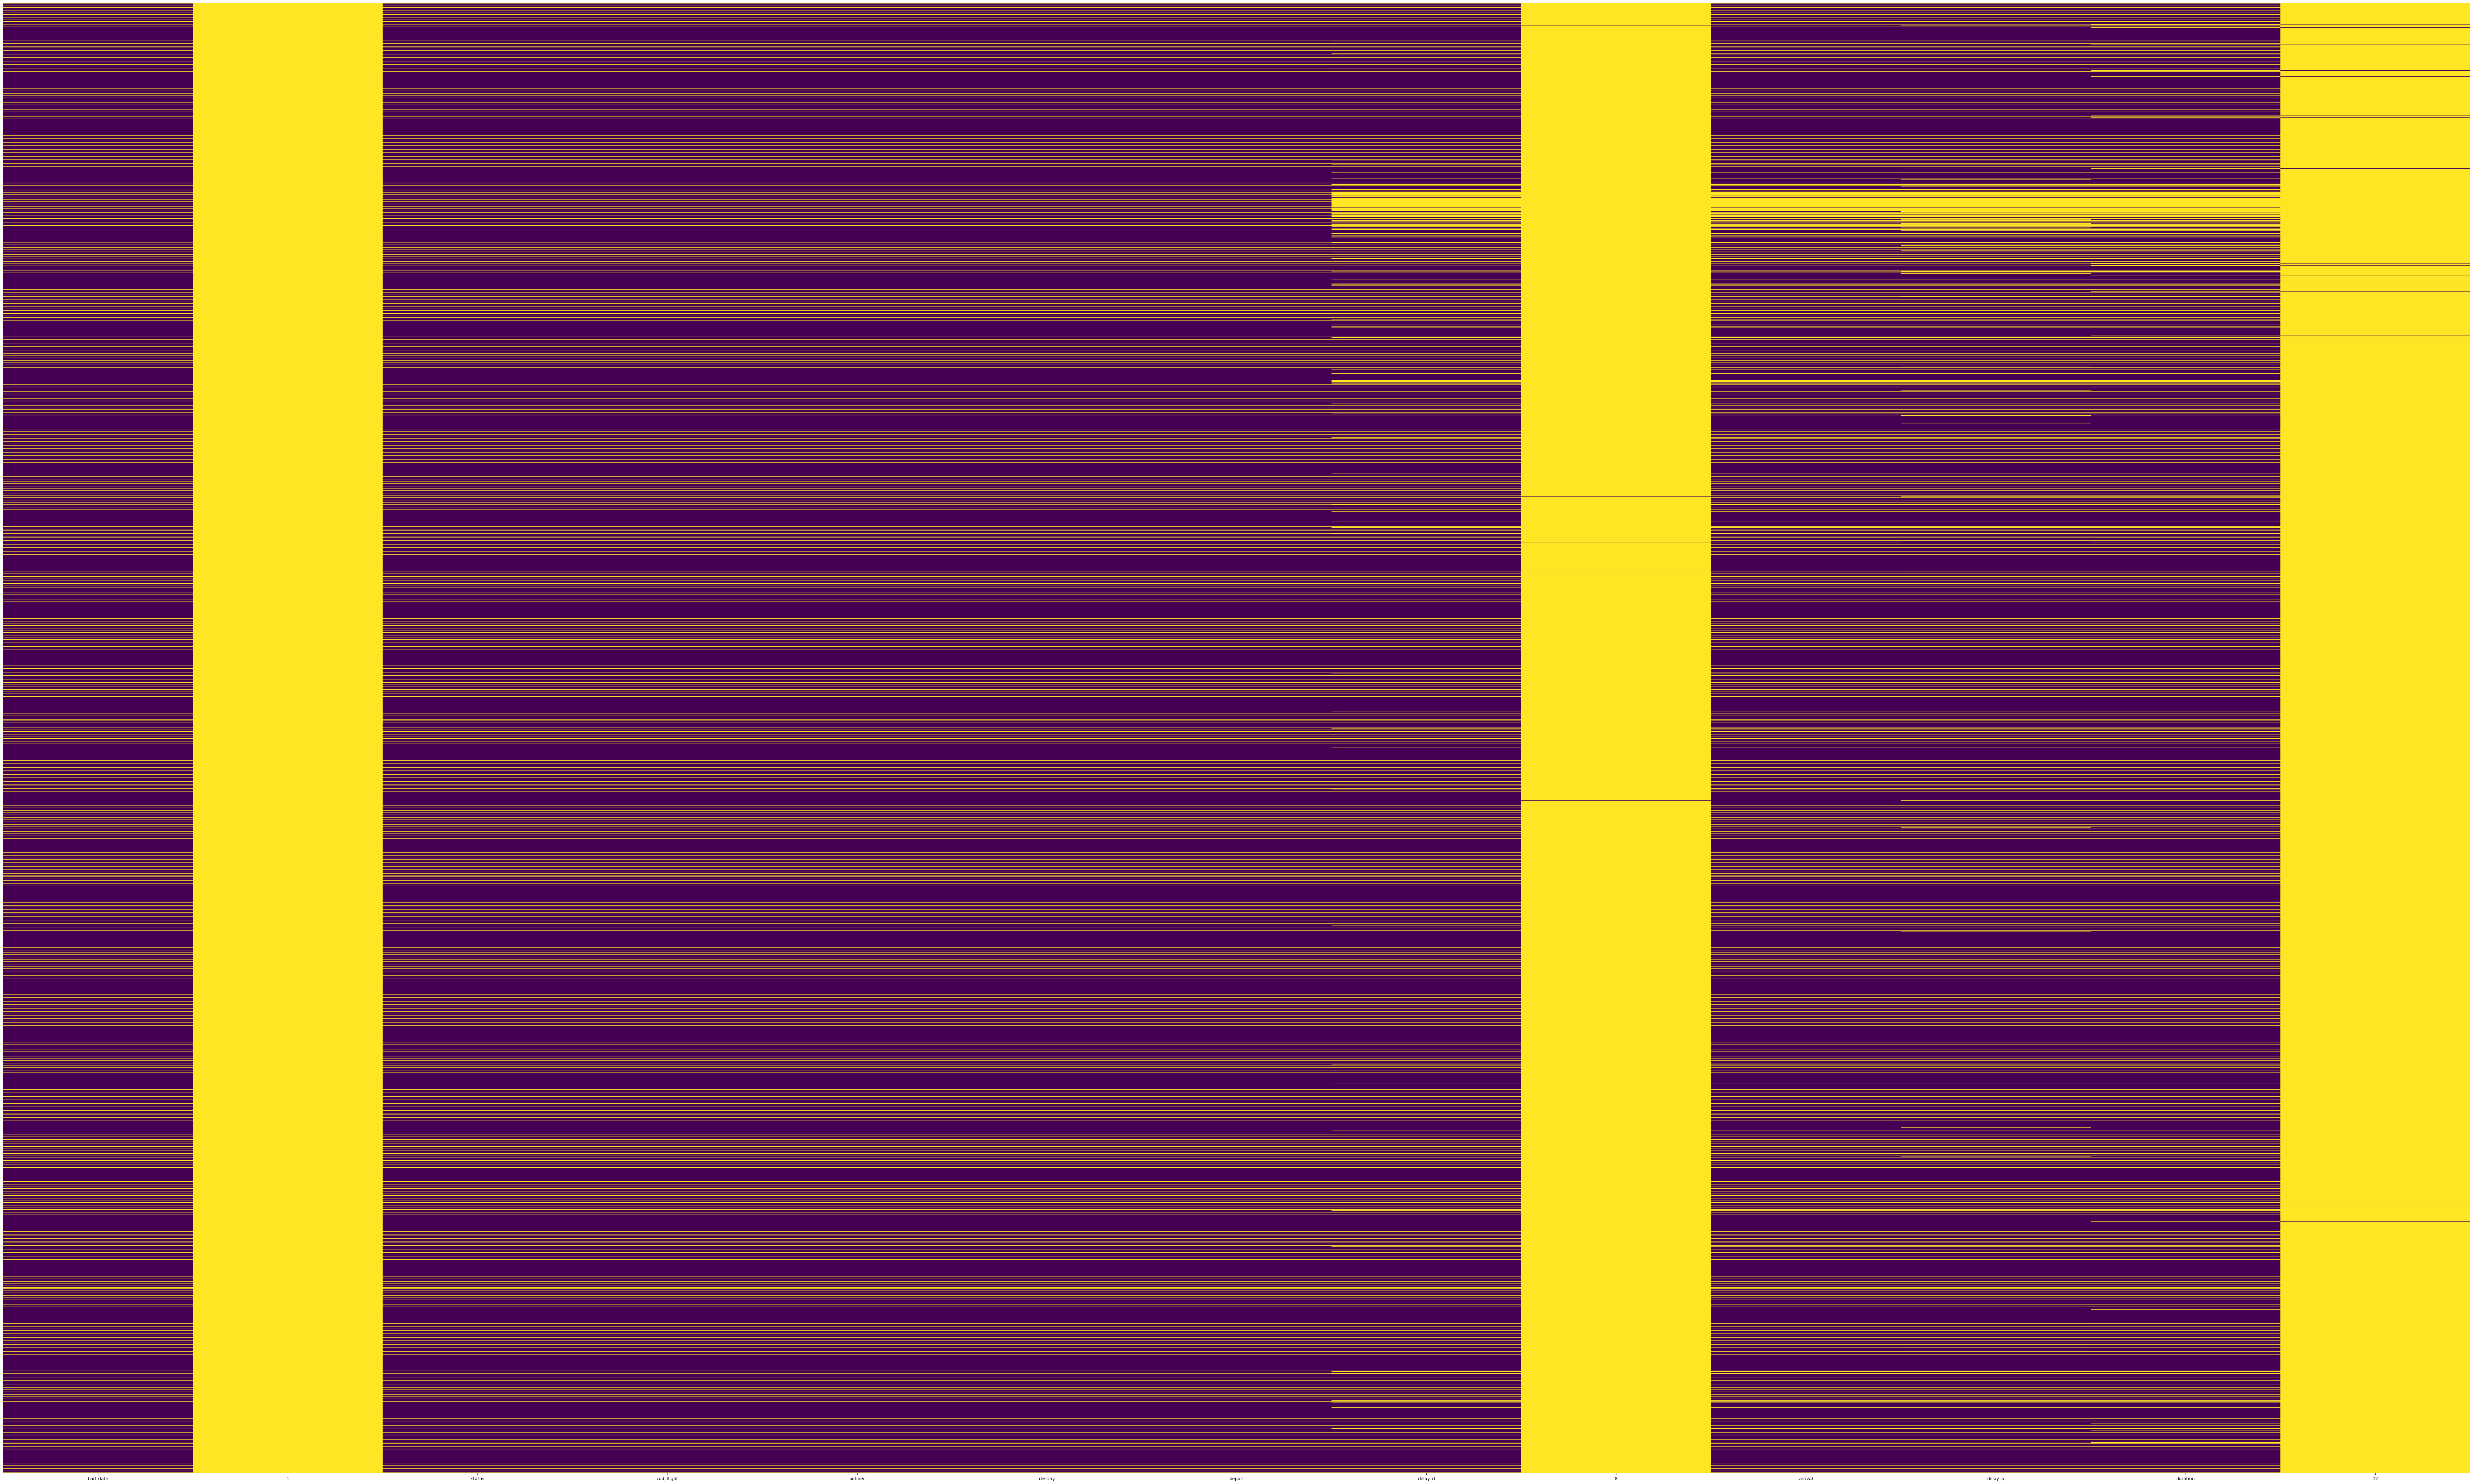

In [9]:
check_nan(fl)

## Se eliminan 3 columnas que tiene todos los valores nulos. Además se comprueba que se han ido generando periodicamente registros con todos los valores nulos en el proceso de extracción, por lo que se eliminan tambien todos estos registros.

In [10]:
fl = fl.drop(['12'], axis=1)
fl = fl.drop(['1'], axis=1)
fl = fl.drop(['8'], axis=1)

In [11]:
fl = fl.dropna(subset="airliner",axis = 0)

## Se vuelven a checkear los nulos, y se sustituyen los pocos que quedan (generalmente en registros de vuelos cancelados donde no hay datos de hora de salida e información de llegada) por "-".

'N nan cols: 4'

delay_d     4.140733
arrival     4.148550
delay_a     5.455929
duration    6.002574
dtype: float64

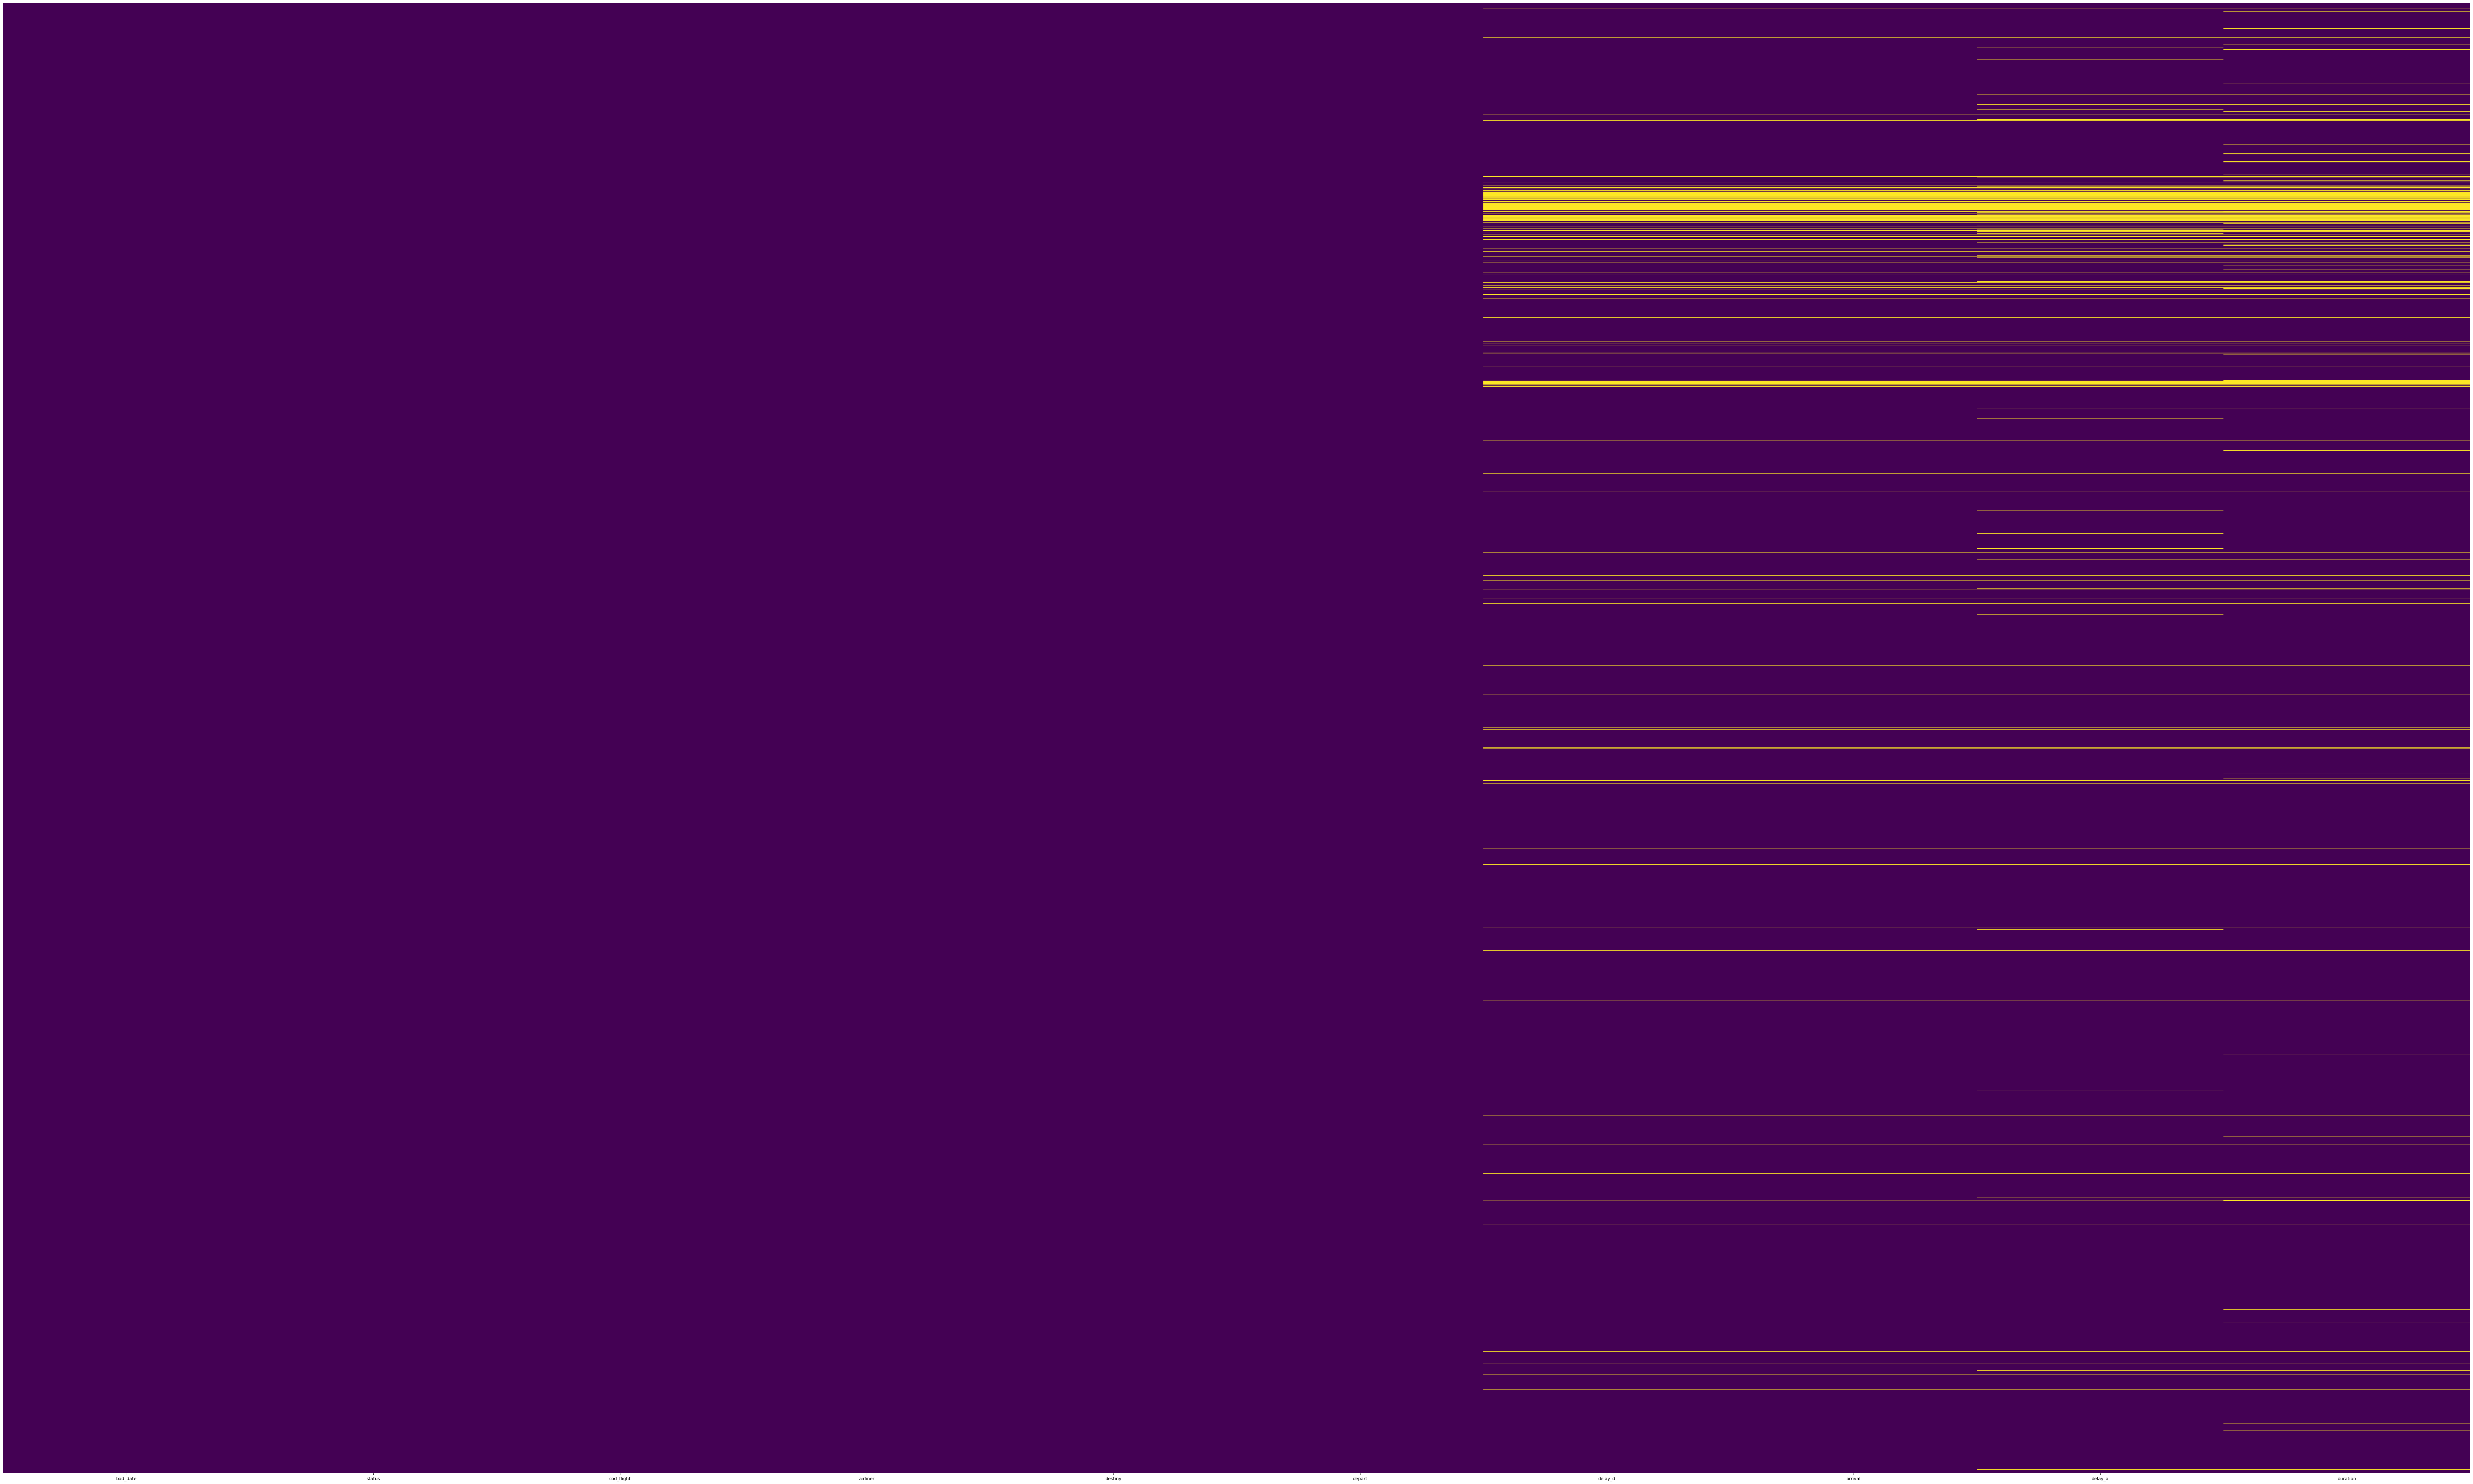

In [12]:
check_nan(fl)

In [13]:
fl.delay_d[fl.delay_d.isna()] = "-"
fl.arrival[fl.arrival.isna()] = "-"
fl.delay_a[fl.delay_a.isna()] = "-"
fl.duration[fl.duration.isna()] = "-"

In [17]:
fl.shape

(332574, 10)

## Se eliminan los registros duplicados si los hubiere, y se eliminan aquellos registros de vuelos donde el estado sigue siendo *"Live"*.

In [18]:
fl = fl.drop_duplicates()

In [19]:
fl.shape 

(307383, 10)

In [20]:
fl[fl["status"] == "Live"].shape

(1, 10)

In [21]:
fl = fl[fl['status'] != 'Live']

In [1]:
pd.set_option('display.max_rows', None)
fl.bad_date.value_counts()

## Se genera una nueva columna con el día de la semana del vuelo, extrayendolo de la columna llamada *"bad_date"*.

In [23]:
dias_semana = {
    'Mon': 'Monday',
    'Tue': 'Tuesday',
    'Wed': 'Wednesday',
    'Thu': 'Thursday',
    'Fri': 'Friday',
    'Sat': 'Saturday',
    'Sun': 'Sunday'
}

In [24]:
fl['week_day'] = fl['bad_date'].str[:3].map(dias_semana)

In [25]:
fl.week_day.value_counts()

Friday       46997
Sunday       45957
Monday       45146
Thursday     43496
Wednesday    43105
Saturday     41571
Tuesday      41110
Name: week_day, dtype: int64

In [26]:
fl = fl.reset_index()

In [27]:
fl.head()

,index,bad_date,status,cod_flight,airliner,destiny,depart,delay_d,arrival,delay_a,duration,week_day
0,0,"Wed, 01. Jan 2020",Landed,SU2605 AFL2605,Aeroflot,SU/AFL Moscow (SVO / UUEE) 00:10 CET,31. Dec 23:10 UTC 00:08 CET,1min early,07:10 MSK,5min late,5h 2m,Wednesday
1,1,"Wed, 01. Jan 2020",Unknown,LA2485 LPE2485,LATAM Airlines Chile,LA/LAN Lima (LIM / SPJC) 00:40 CET,31. Dec 23:40 UTC 11h 16m,-,-,-,-,Wednesday
2,2,"Wed, 01. Jan 2020",Landed,UX39 AEA039,Air Europa,UX/AEA Quito (UIO / SEQM) 01:35 CET,00:35 UTC 01:50 CET,15min late,07:04 UTC-05,25min early,11h 14m,Wednesday
3,3,"Wed, 01. Jan 2020",Landed,TP1005 TAP1005,TAP - Air Portugal,TP/TAP Porto (OPO / LPPR) 05:45 CET,04:45 UTC 05:45 CET,on time,05:57 WET,27min early,1h 12m,Wednesday
4,4,"Wed, 01. Jan 2020",Landed,KL1698 KLM22A,KLM Royal Dutch Airlines,KL/KLM Amsterdam (AMS / EHAM) 06:00 CET,05:00 UTC 06:00 CET,on time,08:41 CET,3min early,2h 41m,Wednesday


In [28]:
fl = fl.drop(['index'], axis=1)

## Se utiliza una función propia (<span style="color:blue">convertir_fecha</span>) para transformar la columna "bad_date" a un formato Datetime reconocible por pandas.

In [29]:
fl['bad_date'] = fl['bad_date'].apply(convertir_fecha)

In [30]:
fl.week_day.value_counts()

Friday       46997
Sunday       45957
Monday       45146
Thursday     43496
Wednesday    43105
Saturday     41571
Tuesday      41110
Name: week_day, dtype: int64

## Se extraen los códigos IATA e ICAO del vuelo y se introducen en 2 nuevas columnas

In [31]:
fl[['cod_flight_IATA', 'cod_flight_ICAO']] = fl['cod_flight'].str.split(' ', expand=True)


In [34]:
fl[fl.cod_flight_ICAO.isna()].shape

(14567, 13)

## Se elimina la columna cod_flight una vez separados los 2 códigos

In [35]:
fl = fl.drop(['cod_flight'], axis=1)

## Se crea una funcion propia (<span style="color:blue">separar_valores</span>) que busca y separa en 2 columnas nuevas los códigos IATA e ICAO de la aerolínea que se encuentran en la columna "*destiny*"

In [36]:
separar_valores(fl, 'destiny')

In [40]:
fl[fl.cod_airliner_IATA.isnull()].airliner.value_counts()

VistaJet Malta              8
Flexjet                     3
Executive Jet Management    1
Name: airliner, dtype: int64

In [38]:
# Definir una función para aplicar a las columnas
def actualizar_codigos(row):
    if row['airliner'] == 'Plus Ultra':
        return pd.Series({'cod_airliner_IATA': 'PU', 'cod_airliner_ICAO': 'PUE'})
    elif row['airliner'] == 'Airest':
        return pd.Series({'cod_airliner_IATA': '??', 'cod_airliner_ICAO': 'AEG'})
    else:
        return pd.Series({'cod_airliner_IATA': row['cod_airliner_IATA'], 'cod_airliner_ICAO': row['cod_airliner_ICAO']})

# Aplicar la función a las columnas específicas
fl[['cod_airliner_IATA', 'cod_airliner_ICAO']] = fl.apply(actualizar_codigos, axis=1)


In [39]:
pd.set_option('display.max_columns', None)

##  Se crea una funcion propia (<span style="color:blue">extraer_valores</span>) que busca y separa en 3 columnas nuevas los códigos IATA e ICAO y el nombre de la ciudad de destino que se encuentran en la columna "*destiny*".

In [41]:
extraer_valores(fl, 'destiny')

In [42]:
fl = fl.dropna(subset="cod_airliner_IATA",axis = 0)

##  Se crea una funcion propia (<span style="color:blue">extraer_hora</span>) para extraer la hora programada de salida del vuelo, que se espera encontrar en la columna "*depart*"

In [43]:
extraer_hora(fl, 'destiny')

In [ ]:
# fl[fl.depart_time.isna()].status.value_counts()

##  Se crea una funcion propia (<span style="color:blue">extraer_segunda_hora</span>) para extraer la hora real de salida del vuelo, que se espera encontrar en la columna "*depart*"

In [44]:
extraer_segunda_hora(fl, 'depart')


In [45]:
fl.depart_time[fl.depart_time.isna()] = "-"

In [46]:
fl.head()

,bad_date,status,airliner,destiny,depart,delay_d,arrival,delay_a,duration,week_day,cod_flight_IATA,cod_flight_ICAO,cod_airliner_IATA,cod_airliner_ICAO,City,cod_airport_IATA,cod_airport_ICAO,Scheduled_dep,depart_time
0,2020-01-01,Landed,Aeroflot,SU/AFL Moscow (SVO / UUEE) 00:10 CET,31. Dec 23:10 UTC 00:08 CET,1min early,07:10 MSK,5min late,5h 2m,Wednesday,SU2605,AFL2605,SU,AFL,Moscow,SVO,UUEE,00:10,00:08
1,2020-01-01,Unknown,LATAM Airlines Chile,LA/LAN Lima (LIM / SPJC) 00:40 CET,31. Dec 23:40 UTC 11h 16m,-,-,-,-,Wednesday,LA2485,LPE2485,LA,LAN,Lima,LIM,SPJC,00:40,-
2,2020-01-01,Landed,Air Europa,UX/AEA Quito (UIO / SEQM) 01:35 CET,00:35 UTC 01:50 CET,15min late,07:04 UTC-05,25min early,11h 14m,Wednesday,UX39,AEA039,UX,AEA,Quito,UIO,SEQM,01:35,01:50
3,2020-01-01,Landed,TAP - Air Portugal,TP/TAP Porto (OPO / LPPR) 05:45 CET,04:45 UTC 05:45 CET,on time,05:57 WET,27min early,1h 12m,Wednesday,TP1005,TAP1005,TP,TAP,Porto,OPO,LPPR,05:45,05:45
4,2020-01-01,Landed,KLM Royal Dutch Airlines,KL/KLM Amsterdam (AMS / EHAM) 06:00 CET,05:00 UTC 06:00 CET,on time,08:41 CET,3min early,2h 41m,Wednesday,KL1698,KLM22A,KL,KLM,Amsterdam,AMS,EHAM,06:00,06:00


## Se eliminan las columnas "sucias" "*destiny*" y "*depart*" y se sustituyen los valores "scheduled" por "" en la columna "*duration*".

In [47]:
fl = fl.drop(['destiny'], axis=1)
fl = fl.drop(['depart'], axis=1)

In [48]:
fl['duration'] = fl['duration'].str.replace('scheduled', '')

In [50]:
fl['duration'] = fl['duration'].str.replace('Estimated', '')

In [2]:
# fl.duration.value_counts()

##  Se crea una funcion propia (<span style="color:blue">redondear_horas</span>) para redondear la duracion del vuelo en horas, y poner "1h" en los vuelos de ">1h".

In [51]:
fl['duration'] = fl['duration'].apply(redondear_horas)

In [52]:
fl['duration'] = fl['duration'].str.replace(' ', '')

In [54]:
fl["duration"][fl["duration"]==""] = "-"

In [3]:
# fl.delay_a.value_counts()

## Se crea una nueva columna que combine la fecha y la hora prevista de salida de vuelo en formato datetime, para luego poder ordenar los vuelos cronológicamente.

In [56]:
fl['Departure_date_time'] = pd.to_datetime(fl['bad_date'] + ' ' + fl['Scheduled_dep'])

In [57]:
fl = fl.sort_values(by='Departure_date_time', ascending=False)

In [58]:
fl = fl.reset_index(drop = True)

##  Se crea una funcion propia (<span style="color:blue">asignar_estado_departure</span>) que busca el estado de la salida del vuelo que se espera encontrar en la columna "*delay_d*" y se crea una nueva columna.

In [61]:
fl['dep_situation'] = fl['delay_d'].apply(asignar_estado_departure)

In [4]:
# fl.delay_d.value_counts()

##  Se crea una funcion propia (<span style="color:blue">calcular_minutos</span>) que suma los minutos de retraso o adelanto en la salida en función del estado del departure.

In [63]:
fl['dep_mins_of_delay'] = fl['delay_d'].apply(calcular_minutos)

In [65]:
fl[fl.dep_mins_of_delay.isna()]

,bad_date,status,airliner,delay_d,arrival,delay_a,duration,week_day,cod_flight_IATA,cod_flight_ICAO,cod_airliner_IATA,cod_airliner_ICAO,City,cod_airport_IATA,cod_airport_ICAO,Scheduled_dep,depart_time,Departure_date_time,dep_situation,dep_mins_of_delay


## Se aplica tambien la función  (<span style="color:blue">calcular_minutos</span>) para las llegadas.

In [66]:
fl['arr_mins_of_delay'] = fl['delay_a'].apply(calcular_minutos)


In [67]:
fl[["delay_d","dep_mins_of_delay","delay_a","arr_mins_of_delay"]].head(10)

,delay_d,dep_mins_of_delay,delay_a,arr_mins_of_delay
0,4min late,4,14min early,-14
1,21min late,21,13min early,-13
2,24min late,24,11min early,-11
3,24min late,24,8min late,8
4,22min late,22,8min early,-8
5,8min late,8,28min early,-28
6,-,-,-,-
7,17min late,17,11min late,11
8,13min late,13,35min early,-35
9,22min late,22,on time,0


##  Se crea una funcion propia (<span style="color:blue">calcular_diferencia</span>) que calcula la diferencia entre los minutos de retraso/adelanto en la salida y la llegada para ver anomalías en los registros.

In [68]:
fl["resta"] = fl.apply(calcular_diferencia, axis=1)

In [69]:
fl[["delay_d","dep_mins_of_delay","delay_a","arr_mins_of_delay","resta"]].head()

,delay_d,dep_mins_of_delay,delay_a,arr_mins_of_delay,resta
0,4min late,4,14min early,-14,18
1,21min late,21,13min early,-13,34
2,24min late,24,11min early,-11,35
3,24min late,24,8min late,8,16
4,22min late,22,8min early,-8,30


In [70]:
len(fl[abs(fl.resta) > 100])

1189

## Se aplica tambien la función  (<span style="color:blue">asignar_estado_departure</span>) para las llegadas.

In [71]:
fl['arr_situation'] = fl['delay_a'].apply(asignar_estado_departure)

In [72]:
fl.arr_situation.value_counts()

early      195515
late        78530
-           17054
on time     16271
Name: arr_situation, dtype: int64

## Se añade un *id* a cada uno de los vuelos

In [73]:
fl['flight_id'] = range(1, len(fl) + 1)

## Se eliminan columnas sucias y se reordenan las restantes cambiando alguno de sus nombres.

In [74]:
fl = fl.drop(['delay_d'], axis=1)
fl = fl.drop(['delay_a'], axis=1)

In [75]:
reorder = ["flight_id","Departure_date_time","cod_flight_IATA","cod_flight_ICAO","bad_date","week_day","status","airliner","cod_airliner_IATA","cod_airliner_ICAO",
           "Scheduled_dep","depart_time","dep_situation","dep_mins_of_delay","City","cod_airport_IATA","cod_airport_ICAO","arrival",
           "arr_situation","arr_mins_of_delay","duration","resta"]
fl = fl[reorder]

In [78]:
fl.tail()

,flight_id,departure_date_time,cod_flight_IATA,cod_flight_ICAO,day,week_day,status,airliner,cod_airliner_IATA,cod_airliner_ICAO,Scheduled_dep,depart_time,dep_situation,dep_mins_of_delay,city,cod_airport_IATA,cod_airport_ICAO,arrival,arr_situation,arr_mins_of_delay,duration,resta
307365,307366,2020-01-01 06:00:00,KL1698,KLM22A,2020-01-01,Wednesday,Landed,KLM Royal Dutch Airlines,KL,KLM,06:00,06:00,on time,0,Amsterdam,AMS,EHAM,08:41 CET,early,-3,3h,3
307366,307367,2020-01-01 05:45:00,TP1005,TAP1005,2020-01-01,Wednesday,Landed,TAP - Air Portugal,TP,TAP,05:45,05:45,on time,0,Porto,OPO,LPPR,05:57 WET,early,-27,1h,27
307367,307368,2020-01-01 01:35:00,UX39,AEA039,2020-01-01,Wednesday,Landed,Air Europa,UX,AEA,01:35,01:50,late,15,Quito,UIO,SEQM,07:04 UTC-05,early,-25,11h,40
307368,307369,2020-01-01 00:40:00,LA2485,LPE2485,2020-01-01,Wednesday,Unknown,LATAM Airlines Chile,LA,LAN,00:40,-,-,-,Lima,LIM,SPJC,-,-,-,-,0
307369,307370,2020-01-01 00:10:00,SU2605,AFL2605,2020-01-01,Wednesday,Landed,Aeroflot,SU,AFL,00:10,00:08,early,-1,Moscow,SVO,UUEE,07:10 MSK,late,5,5h,-6


In [77]:
fl = fl.rename(columns ={'City':'city', 'Departure_date_time':'departure_date_time', "bad_date": "day"})

## Nos quedamos exclusivamente con los vuelos del rango de fechas deseados.

In [79]:
fl = fl[(fl["departure_date_time"] < "2022-11-01") & (fl["departure_date_time"] >= "2020-01-01")]

## Se reindexa y se exportan los datos limpios en formato *csv*.

In [80]:
fl['flight_id'] = range(1, len(fl) + 1)
fl = fl.reset_index(drop = True)
fl.head()

,flight_id,departure_date_time,cod_flight_IATA,cod_flight_ICAO,day,week_day,status,airliner,cod_airliner_IATA,cod_airliner_ICAO,Scheduled_dep,depart_time,dep_situation,dep_mins_of_delay,city,cod_airport_IATA,cod_airport_ICAO,arrival,arr_situation,arr_mins_of_delay,duration,resta
0,1,2022-10-31 23:59:00,IB6841,IBE6841,2022-10-31,Monday,Landed,Iberia,IB,IBE,23:59,00:21,late,22,Buenos Aires,EZE,SAEZ,08:55 UTC-03,on time,0,-,22
1,2,2022-10-31 23:59:00,IB6833,IBE6833,2022-10-31,Monday,Landed,Iberia,IB,IBE,23:59,01:22,late,83,Santiago,SCL,SCEL,08:58 UTC-03,early,-21,-,104
2,3,2022-10-31 23:55:00,IB6409,IBE6409,2022-10-31,Monday,Landed,Iberia,IB,IBE,23:55,00:12,late,17,Mexico City,MEX,MMMX,04:45 CST,early,-29,-,46
3,4,2022-10-31 23:55:00,UX41,AEA041,2022-10-31,Monday,Landed,Air Europa,UX,AEA,23:55,00:18,late,23,Buenos Aires,EZE,SAEZ,08:24 UTC-03,early,-25,-,48
4,5,2022-10-31 23:55:00,UX175,AEA175,2022-10-31,Monday,Landed,Air Europa,UX,AEA,23:55,08:16,late,501,Lima,LIM,SPJC,13:18 UTC-05,late,443,-,58


In [88]:
fl.shape

(306924, 22)

In [86]:
fl[fl.city.isna()].shape

(437, 22)

In [87]:
fl = fl[fl.city.notna()]

In [89]:
fl.info(memory_usage = "deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306924 entries, 0 to 307360
Data columns (total 22 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   flight_id            306924 non-null  int64         
 1   departure_date_time  306924 non-null  datetime64[ns]
 2   cod_flight_IATA      306924 non-null  object        
 3   cod_flight_ICAO      292458 non-null  object        
 4   day                  306924 non-null  object        
 5   week_day             306924 non-null  object        
 6   status               306924 non-null  object        
 7   airliner             306924 non-null  object        
 8   cod_airliner_IATA    306924 non-null  object        
 9   cod_airliner_ICAO    306924 non-null  object        
 10  Scheduled_dep        306924 non-null  object        
 11  depart_time          306924 non-null  object        
 12  dep_situation        306924 non-null  object        
 13  dep_mins_of_de

In [ ]:
fl.status.value_counts()

In [90]:
fl.to_csv("../data/flights/flights2020_2022.csv", index=False)